
**方程与条件**:
*   方程: $\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}$
*   参数: $L=1\text{ m}, \alpha=0.01\text{ m}^2/\text{s}$
*   初始条件: $T(x,0) = \sin(\pi x)$
*   边界条件: $T(0,t) = T(1,t) = 0$
*   稳定性条件: $r \le 0.5$


## 1. 数值求解实现 (Numerical Solution)
在此部分，我们对一维热传导方程进行离散化，并使用显式差分格式进行迭代求解。

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 设置绘图风格
plt.style.use('default')
# 尝试支持中文，如果乱码可以尝试更换字体或忽略
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'DejaVu Sans'] 
plt.rcParams['axes.unicode_minus'] = False 

# 1. 设置参数
L = 1.0         # 杆长 (m)
alpha = 0.01    # 热扩散系数 (m^2/s)
T_max = 5.0     # 模拟总时间 (s)

# 空间离散化
Nx = 50                 # 空间网格数
dx = L / Nx             # 空间步长
x = np.linspace(0, L, Nx+1)

# 时间离散化 (满足稳定性条件 r <= 0.5)
# r = alpha * dt / dx^2
# dt = r * dx^2 / alpha
r = 0.4                 # 选取一个满足 r <= 0.5 的值
dt = r * dx**2 / alpha  # 根据 r 计算时间步长
Nt = int(T_max / dt) + 1 # 时间步数
t_eval = np.array([0, 0.1, 0.5, 1.0, 5.0]) # 需要评估的时间点

print(f"网格参数: dx = {dx:.4f} m, dt = {dt:.4f} s")
print(f"稳定性参数: r = {r:.4f} (<= 0.5, 稳定)")

# 2. 数值求解 (显式差分法)
# 初始化温度矩阵 [时间, 空间]
T = np.zeros((Nt, Nx+1))

# 初始条件 T(x, 0) = sin(pi * x)
T[0, :] = np.sin(np.pi * x)

# 边界条件 (虽然初始化已为0，但显式设定以防万一)
T[:, 0] = 0.0
T[:, -1] = 0.0

# 迭代求解
for n in range(0, Nt-1):
    # T_i^{n+1} = T_i^n + r * (T_{i+1}^n - 2T_i^n + T_{i-1}^n)
    # 利用切片操作加速计算 (向量化)
    T[n+1, 1:-1] = T[n, 1:-1] + r * (T[n, 2:] - 2*T[n, 1:-1] + T[n, 0:-2])

print(f"计算完成。总时间步数: {Nt}")

网格参数: dx = 0.0200 m, dt = 0.0160 s
稳定性参数: r = 0.4000 (<= 0.5, 稳定)
计算完成。总时间步数: 313


## 2. 结果分析：数值解与解析解对比
我们将不同时刻的数值模拟结果与解析解 $T(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)$ 进行对比。

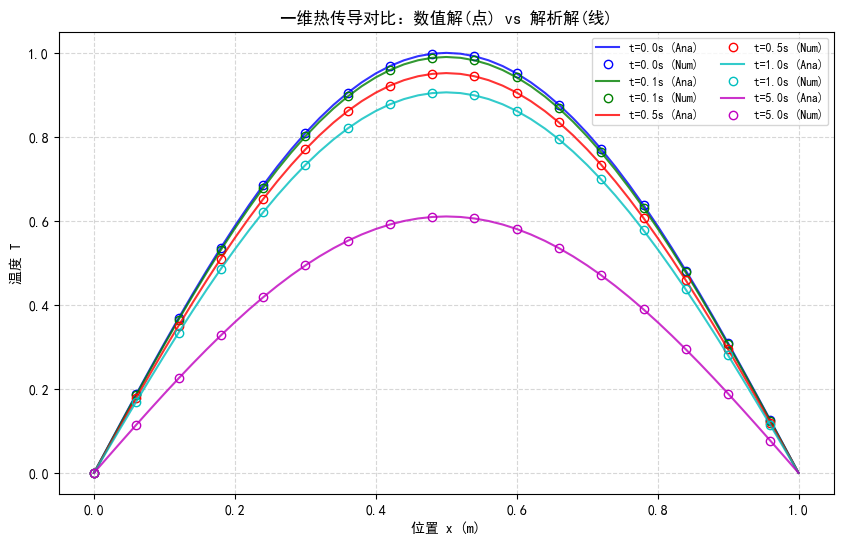

最大数值误差 (Max Numerical Error): 6.747269e-04
说明: 实线(-)代表解析解，空心圆点(o)代表数值解。点的重合度越高表示误差越小。


In [8]:
# 3. 比较与绘图
plt.figure(figsize=(10, 6))

# 解析解函数
def analytical_solution(x, t, alpha):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

colors = ['b', 'g', 'r', 'c', 'm']
markers = ['o', 's', '^', 'v', 'D'] # 不同时间点也可以用不同形状，或者统一用圆形
max_error = 0

# 为了图例清晰，我们在循环外手动构造图例，或者在循环内巧妙设置
# 这里采用：只在图例中显示时间对应的颜色，并通过副标题或标注说明 点=数值解，线=解析解

for i, t_val in enumerate(t_eval):
    # 找到最接近的时间步索引
    n_idx = int(t_val / dt)
    if n_idx >= Nt: n_idx = Nt - 1
    
    # 提取数值解
    T_num = T[n_idx, :]
    
    # 计算解析解
    T_ana = analytical_solution(x, t_val, alpha)
    
    # 计算误差
    current_error = np.max(np.abs(T_num - T_ana))
    max_error = max(max_error, current_error)
    
    # 绘图
    # 解析解：实线 (Solid Line)
    # 仅给第一个解析解添加 'Model' 标签用于说明，或者全部添加由图例管理
    plt.plot(x, T_ana, '-', color=colors[i], linewidth=1.5, alpha=0.8, 
             label=f't={t_val}s (Ana)')
             
    # 数值解：散点 (Scatter Points)
    # 使用切片 [::2] 稀疏显示点，避免过于密集遮挡线条
    plt.plot(x[::3], T_num[::3], 'o', color=colors[i], markerfacecolor='none', markersize=6, 
             label=f't={t_val}s (Num)')

plt.title('一维热传导对比：数值解(点) vs 解析解(线)')
plt.xlabel('位置 x (m)')
plt.ylabel('温度 T')

# 优化图例：分两栏显示，一栏数值，一栏解析
plt.legend(ncol=2, loc='upper right', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"最大数值误差 (Max Numerical Error): {max_error:.6e}")
print("说明: 实线(-)代表解析解，空心圆点(o)代表数值解。点的重合度越高表示误差越小。")

## 3. 可视化：温度场随时间的演化 (3D & Heatmap)
使用3D曲面图和热力图直观展示热量从中心向两侧扩散并随时间衰减的过程。

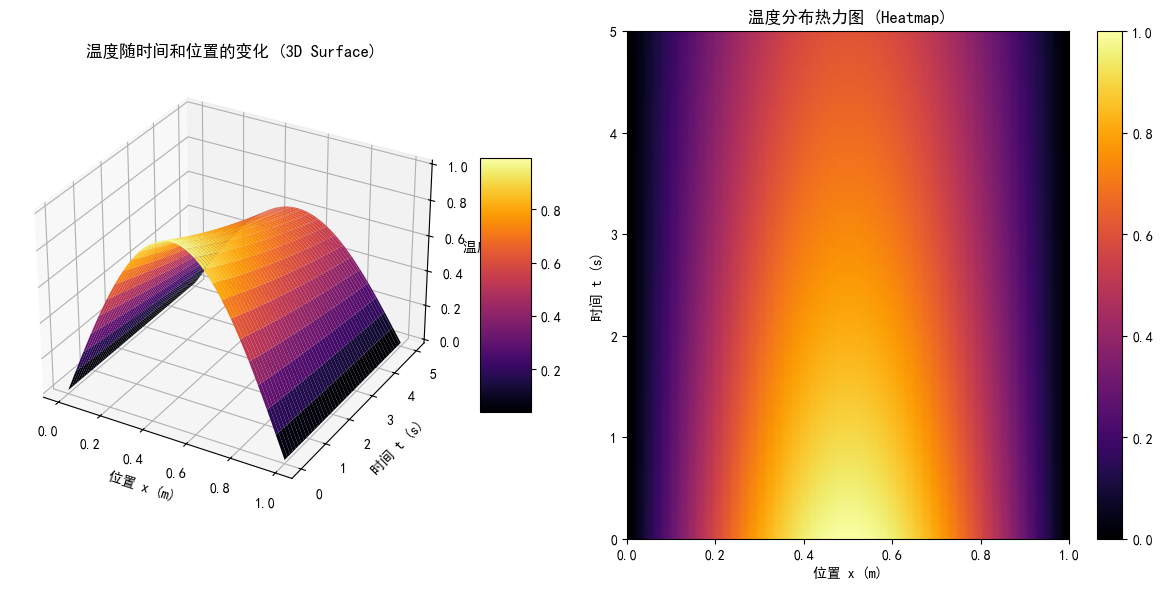

In [9]:
# 4. 可视化：3D 热力演化图
X, T_grid = np.meshgrid(x, np.linspace(0, T_max, Nt))

fig = plt.figure(figsize=(12, 6))

# 3D Surface Plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, T_grid, T, cmap='inferno', edgecolor='none')
ax1.set_title('温度随时间和位置的变化 (3D Surface)')
ax1.set_xlabel('位置 x (m)')
ax1.set_ylabel('时间 t (s)')
ax1.set_zlabel('温度 T')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# Heatmap
ax2 = fig.add_subplot(122)
im = ax2.imshow(T, aspect='auto', origin='lower', 
                extent=[0, L, 0, T_max], cmap='inferno')
ax2.set_title('温度分布热力图 (Heatmap)')
ax2.set_xlabel('位置 x (m)')
ax2.set_ylabel('时间 t (s)')
fig.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()